In [0]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import librosa
from librosa import display
import numpy as np
import IPython.display as ipd

In [0]:
SOUND_FOLDER = '/content/drive/My Drive/sleep_sounds/'
SPECT_FOLDER = '/content/drive/My Drive/sleep_spectograms/'

# Data Visualisation

We can look at samples with a wave plot (amplitude) or a mel-spectogram, which plots frequencies overtime with a dB colorbar (logAmplitude)

In [0]:
def plot_sound(path):
  """Mel Spectrogram"""
  samples, sample_rate = librosa.load(f'{SOUND_FOLDER}/{path}')
  fig = plt.figure(figsize=[15, 5])
  ax = fig.add_subplot(111)
  ax.axes.get_yaxis().set_visible(False)
  S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
  display.specshow(librosa.power_to_db(S, ref=np.max))


def plot_wave(path):
  """Amplitude overtime"""
  samples, sample_rate = librosa.load(f'{SOUND_FOLDER}/{path}')
  fig = plt.figure(figsize=[15, 5])
  ax = fig.add_subplot(111)
  S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
  display.waveplot(samples, sr=sample_rate, x_axis='time')

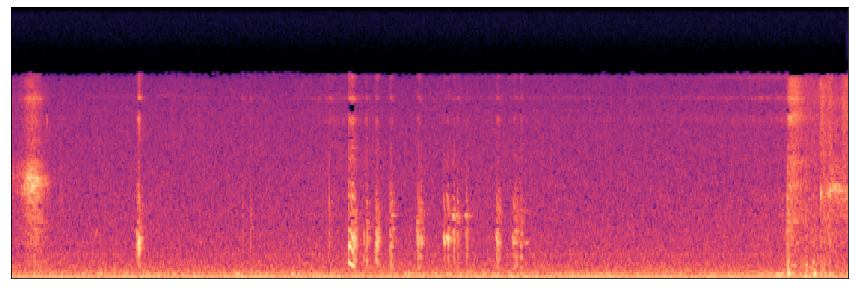

In [6]:
plot_sound("apnea-100.wav")

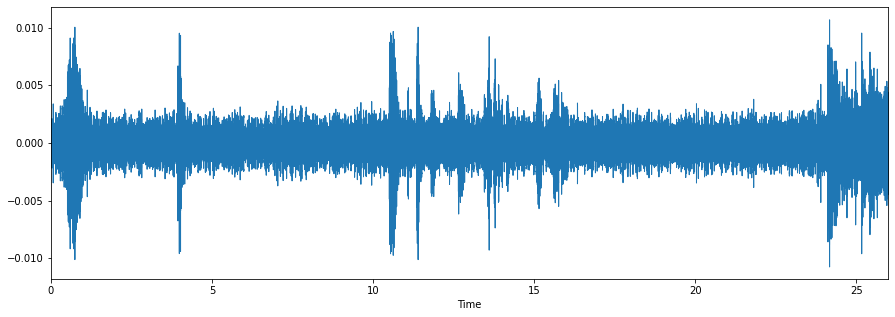

In [7]:
plot_wave("apnea-100.wav")

In [0]:
def split(audio: np.array, sample_rate: float, duration: int = 5, threshold: float = 0.005) -> list:
  """
  Split audio file in sequences
  filtering sequence with amplitude < filter
  """
  audios = [audio[i * sample_rate: (i + duration) * sample_rate] for i in range(int(len(audio) / sample_rate  - duration) + 1)]
  return [clip for clip in audios if np.max(clip) > threshold]

We can listen to a apnea sample with ipd.Audio

In [9]:
y, sample_rate = librosa.load(f'{SOUND_FOLDER}/apnea-100.wav')
audios = split(y, sample_rate, threshold=0.005)
max_amp = list(map(np.max, audios))

ipd.Audio(audios[15], rate=sample_rate)

Each long sample will be splitted in 5s window frames, with an amplitude filter to filter out uninteresting sounds

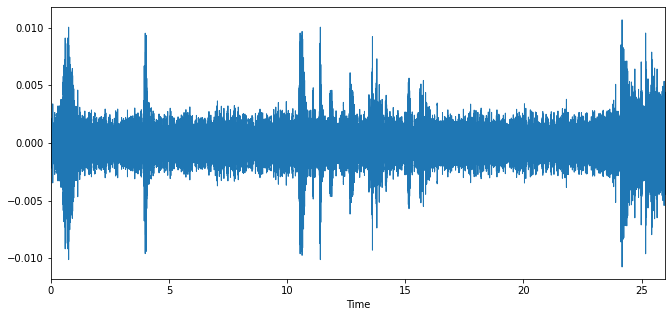

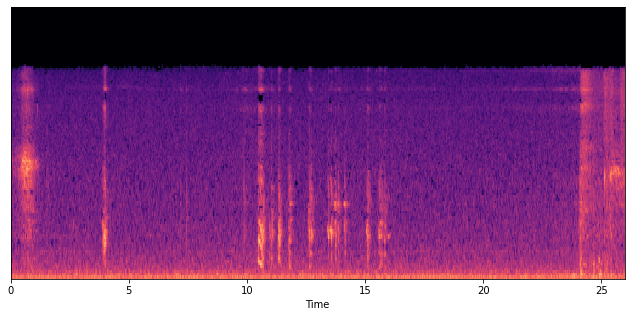

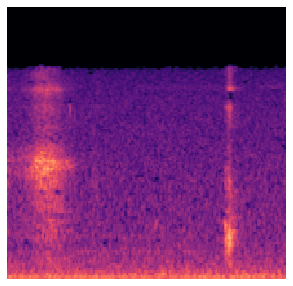

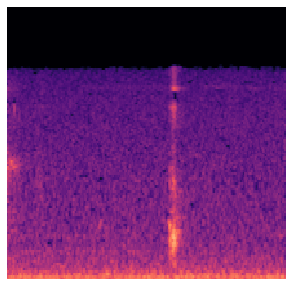

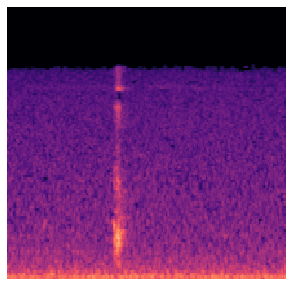

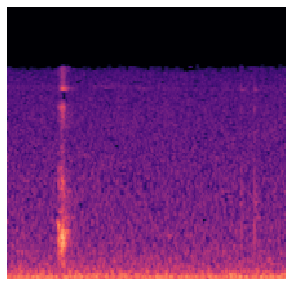

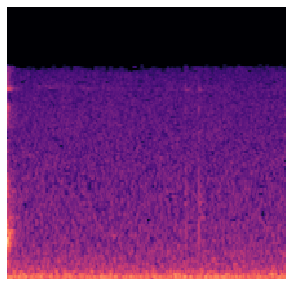

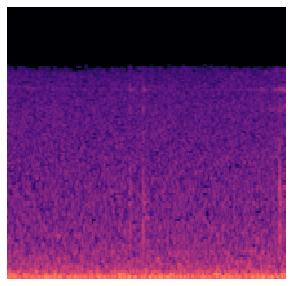

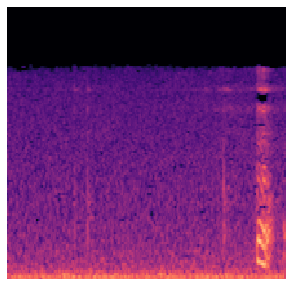

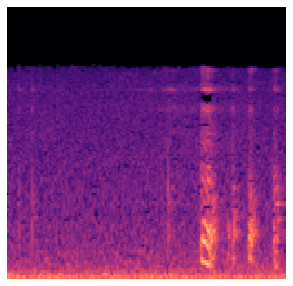

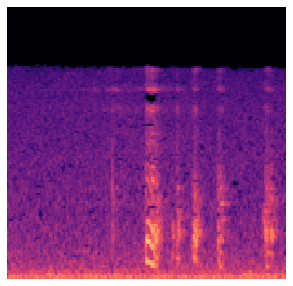

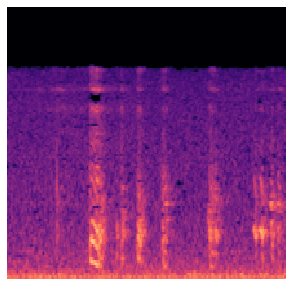

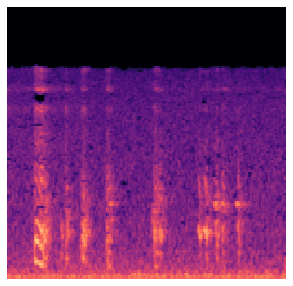

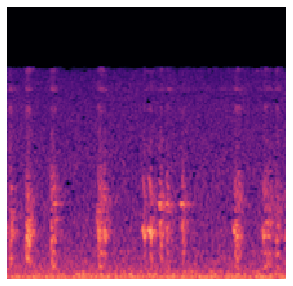

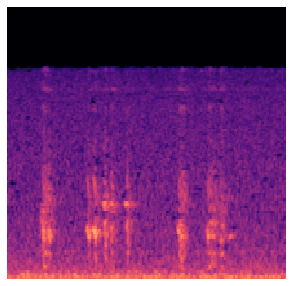

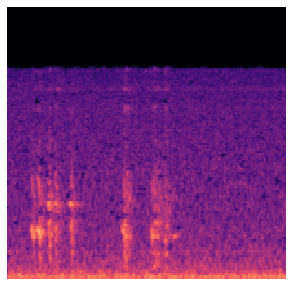

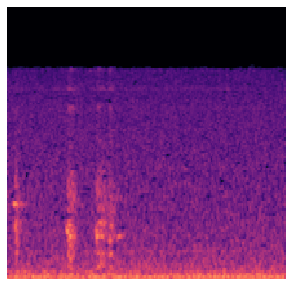

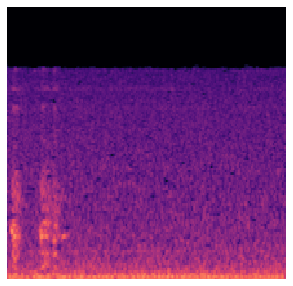

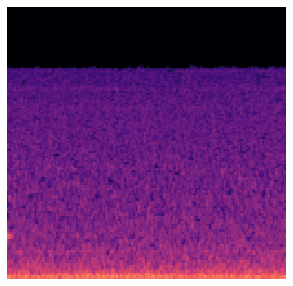

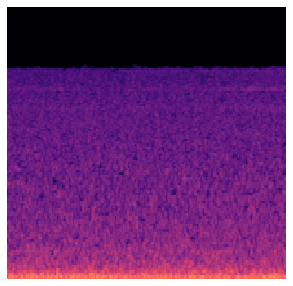

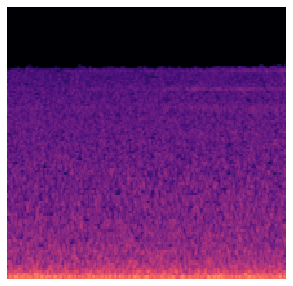

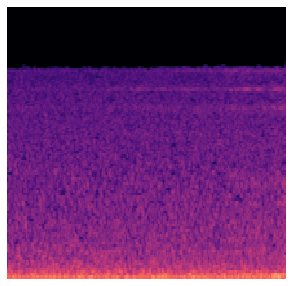

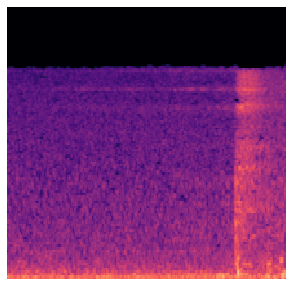

In [118]:
from matplotlib import cm

fig = plt.figure(figsize=[11, 5])
ax = fig.add_subplot(111)
display.waveplot(y, sr=sample_rate, x_axis='time')
plt.show()

ref = np.max(y)

fig = plt.figure(figsize=[11, 5])
ax = fig.add_subplot(111)
ax.axes.get_yaxis().set_visible(False)
S = librosa.feature.melspectrogram(y=y, sr=sample_rate)
S_dB = librosa.power_to_db(S, ref=ref)
librosa.display.specshow(S_dB, x_axis='time',
                        y_axis='mel', sr=sample_rate,
                        fmax=8000,
                        vmin=-50, vmax=20)

plt.show()

for audio in split(y, sample_rate, threshold=0.0025):
  ipd.Audio(audio, rate=sample_rate) # load a NumPy array
  fig = plt.figure(figsize=[5,5])
  ax = fig.add_subplot(111)
  ax.axes.get_xaxis().set_visible(False)
  ax.axes.get_yaxis().set_visible(False)
  ax.set_frame_on(False)
  S = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
  S_dB = librosa.power_to_db(S, ref=ref)
  librosa.display.specshow(S_dB, x_axis='time',
                          y_axis='mel', sr=sample_rate,
                          fmax=8000,
                          vmin=-50, vmax=20)

  plt.show()

# DataSet Generation

In [0]:
import os
import tqdm

from multiprocessing import Pool, TimeoutError
import time
import os

def generate_png(audio_file):
  samples, sample_rate = librosa.load(audio_file)
  threshold = 0.005 if 'apnea' in audio_file else 0.0025
  for i, audio in enumerate(split(samples, sample_rate, threshold=threshold)):
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    filename  = audio_file.replace('.wav', f'-{i}.png').replace(SOUND_FOLDER, SPECT_FOLDER)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    S = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, x_axis='time',
                            y_axis='mel', sr=sample_rate,
                            fmax=8000,
                            vmin=-50, vmax=20)
    plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close('all')

files = [f'{SOUND_FOLDER}/{f}' for f in os.listdir(SOUND_FOLDER) if '.wav']
start = time.time()
done = 0

with Pool(processes=2) as pool:
    # print same numbers in arbitrary order
    for i in pool.imap_unordered(generate_png, files):
        done = done + 1
        if done % 5 == 0:
          print(done, 'files done', round(100 * done / len(files)), '%', round((time.time() - start) / done, 2), 'sec. per item')